# SMARCC2


[Coffin-Siris syndrome-8 (CSS8)](https://www.omim.org/entry/618362) is inherited autosomal dominant characterized by variable degrees of impaired intellectual development including speech impairment, hypotonia, feeding difficulties, and behavioral abnormalities. Dysmorphic features may or may not be present and include hypertrichosis or thin scalp hair, thick eyebrows, thin upper vermilion, and upturned nose [Machol et al., 2019](https://pubmed.ncbi.nlm.nih.gov/30580808/). 

We performed the following PubMed query on 2024-09-26 

> ("Coffin-Siris syndrome type 8" OR CSS8 OR "Coffin-Siris syndrome 8") AND (SMARCC2 OR "SMARCC2 variants" OR "SMARCC2 mutations") AND ("genotype phenotype correlation" OR " phenotype genotype correlation")


This query returned on article [PMID:34881817](https://pubmed.ncbi.nlm.nih.gov/34881817/), which reported on two individuals affected by CSS8 showing a similar clinical manifestations with two severe variants c.1824_1826del, p.(Leu609del) and  c.1094_1097delAGAA, p.(Lys365Thrfs*12)

Further we found the article: Elucidating the clinical and molecular spectrum of SMARCC2-associated NDD in a cohort of 65 affected individuals - Bosch E, et al (2023), [https://doi.org/10.1016/j.gim.2023.100950)], which reported on the following significant correlations between missense and truncating variants: 

**"_p values missense versus truncating variant cohorts_"** for 
 - Global developmental delay; Intellectual disability (HP:0001263;HP:0001249):          p = 0.005 (FDR-corr: 0.033)
 - Muscular hypotonia (HP:0001252):                                                      p = 0.004 (FDR-corr: 0.033)
 - mild GDD/ID (HP:0011342;HP:0001256):                                                  p = 0.012 (FDR-corr: 0.051)
 - Abnormality of the outer ear (HP:0000356):                                            p = 0.013 (FDR-corr: 0.051)
 - Decreased body weight (HP:0004325):                                                   p = 0.002 (FDR-corr: 0.024)
 - Abnormality of the eye (HP:0000478):                                                  p = 0.000 (FDR-corr: 0.008)
 - Short stature (HP:0004322):                                                           p = 0.006 (FDR-corr: 0.035)
 - Feeding difficulties/failure to thrive (HP:0011968;HP:0001508)                        p = 0.013 (FDR-corr: 0.051)

In [1]:
import gpsea
import hpotk

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo()
print(f'Loaded HPO v{hpo.version}')
print(f"Using genophenocorr version {gpsea.__version__}")

Loaded HPO v2025-01-16
Using genophenocorr version 0.9.6.dev0


### SMARCC2

We use the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for SMARCC2.

In [2]:
from gpsea.preprocessing import configure_default_protein_metadata_service
gene_symbol = 'SMARCC2'
mane_tx_id = 'NM_001330288.2'
mane_protein_id = 'NP_001317217.1'
pms = configure_default_protein_metadata_service()
protein_meta = pms.annotate(mane_protein_id)

In [3]:
from ppktstore.registry import configure_phenopacket_registry
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets

phenopacket_registry = configure_phenopacket_registry()
with phenopacket_registry.open_phenopacket_store('0.1.24') as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))

cohort_creator = configure_caching_cohort_creator(hpo)
cohort, validation = load_phenopackets(  
    phenopackets=phenopackets,
    cohort_creator=cohort_creator,
)
validation.summarize()

Individuals Processed: 100%|██████████| 65/65 [00:02<00:00, 32.38 individuals/s]
Validated under permissive policy
Showing errors and warnings
Phenopackets
  patient #5
    individual
     warnings:
     ·ontology_class of the time_at_last_encounter field cannot be parsed into age. Consider formatting the age as ISO8601 duration (e.g., "P31Y2M" for 31 years and 2 months)
  patient #20
    individual
     warnings:
     ·ontology_class of the time_at_last_encounter field cannot be parsed into age. Consider formatting the age as ISO8601 duration (e.g., "P31Y2M" for 31 years and 2 months)


In [4]:
from gpsea.view import CohortViewer

viewer = CohortViewer(hpo)
viewer.process(cohort=cohort, transcript_id=mane_tx_id)

n,HPO Term
50,Intellectual disability
40,Hypotonia
28,Feeding difficulties
28,Failure to thrive
24,Thin upper lip vermilion
21,Thick eyebrow
21,Mild global developmental delay
20,Autistic behavior
17,Thick lower lip vermilion
17,Everted lower lip vermilion


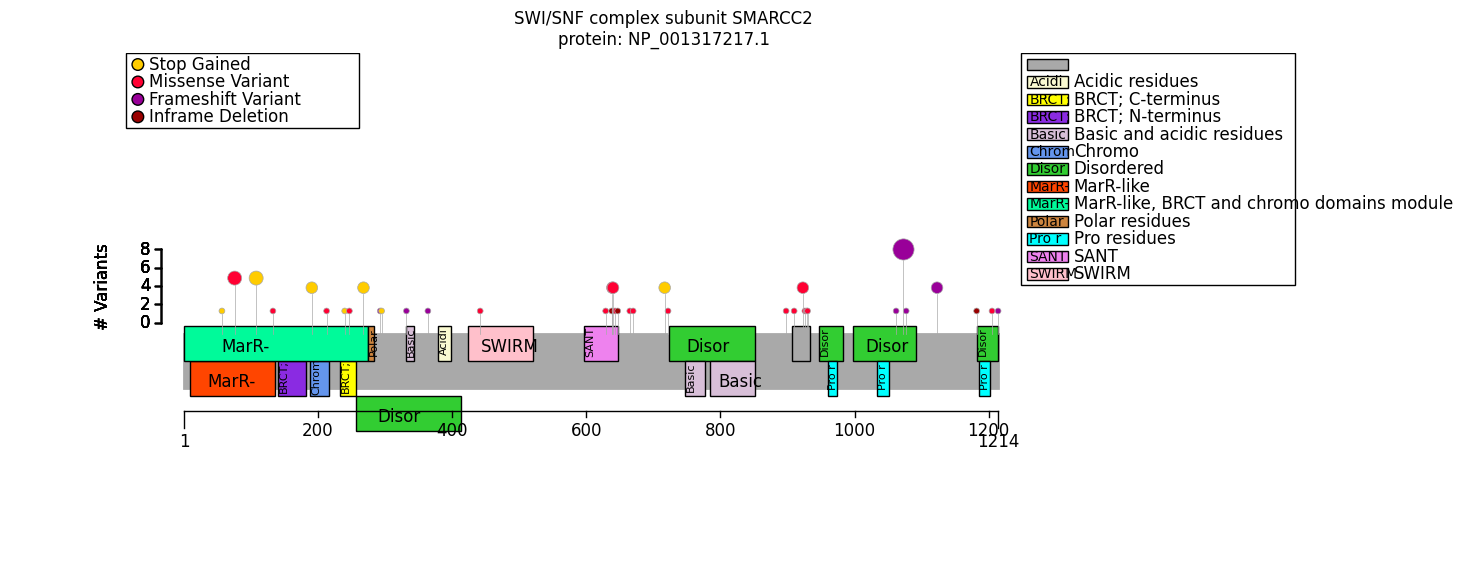

In [5]:
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt

smarcc2_fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein(
    protein_metadata=protein_meta,
    cohort=cohort,
    ax=ax,
)
smarcc2_fig.tight_layout()

In [6]:
from gpsea.view import ProteinVariantViewer
pvv = ProteinVariantViewer(protein_metadata=protein_meta, tx_id=mane_tx_id)
pvv.process(cohort)

Count,Name,Type,Coordinates,Variants
15,"MarR-like, BRCT and chromo domains module",Region,2 - 274,p.Arg192Ter; p.Thr214Ala; p.Pro77Leu; p.Gln58Ter; p.Phe248Ser; p.Arg269Ter; p.Asn134Asp; p.Trp241Ter; p.Tyr109Ter
8,MarR-like,Domain,11 - 136,p.Tyr109Ter; p.Asn134Asp; p.Gln58Ter; p.Pro77Leu
0,BRCT; N-terminus,Domain,141 - 183,
3,Chromo,Domain,190 - 217,p.Arg192Ter; p.Thr214Ala
2,BRCT; C-terminus,Domain,234 - 257,p.Trp241Ter; p.Phe248Ser
6,Disordered,Region,258 - 413,p.Lys365ThrfsTer12; p.Glu334ArgfsTer49; p.Arg269Ter; p.Tyr296Ter; p.Gly294LysfsTer3
0,Polar residues,Compositional bias,276 - 284,
1,Basic and acidic residues,Compositional bias,332 - 344,p.Glu334ArgfsTer49
0,Acidic residues,Compositional bias,380 - 398,
1,SWIRM,Domain,425 - 521,p.Arg443Trp


## Genotype-Phenotype Correlation (GPC) Analysis

In [7]:
from gpsea.analysis.clf import prepare_classifiers_for_terms_of_interest
from gpsea.analysis.pcats import configure_hpo_term_analysis

analysis = configure_hpo_term_analysis(hpo)
pheno_clfs = prepare_classifiers_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

In [8]:
from gpsea.model import VariantEffect
from gpsea.view import MtcStatsViewer
from gpsea.analysis.predicate import variant_effect, anyof
from gpsea.analysis.clf import monoallelic_classifier

missense = variant_effect(VariantEffect.MISSENSE_VARIANT, mane_tx_id)
nonsense = variant_effect(VariantEffect.STOP_GAINED, tx_id=mane_tx_id)
frameshift = variant_effect(VariantEffect.FRAMESHIFT_VARIANT, tx_id=mane_tx_id)
truncating = anyof((nonsense, frameshift))

missense_clf = monoallelic_classifier(
    a_predicate=missense,
    b_predicate=truncating,
    a_label="Missense",
    b_label="Truncating"
)

missense_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=missense_clf,
    pheno_clfs=pheno_clfs,
)

viewer = MtcStatsViewer()
viewer.process(missense_result)

Reason,Count
Skip terms if all counts are identical to counts for a child term,6
"Skipping ""general"" level terms",56
Skipping terms that are rare on the cohort level (in less than 40% of the cohort members),168


In [9]:
from gpsea.view import summarize_hpo_analysis
summarize_hpo_analysis(hpo=hpo, result=missense_result)

Allele group,Missense,Truncating,Corrected p values,p values
Moderate global developmental delay [HP:0011343],10/23 (43%),1/23 (4%),0.298622,0.004148
Mild global developmental delay [HP:0011342],6/23 (26%),14/23 (61%),1.000000,0.036143
Ptosis [HP:0000508],4/20 (20%),0/21 (0%),1.000000,0.047842
Short stature [HP:0004322],7/20 (35%),2/22 (9%),1.000000,0.062211
Intellectual disability [HP:0001249],22/23 (96%),17/23 (74%),1.000000,0.095916
...,...,...,...,...
Hypertonia [HP:0001276],4/23 (17%),4/23 (17%),1.000000,1.000000
Sleep abnormality [HP:0002360],5/22 (23%),5/22 (23%),1.000000,1.000000
Thick lower lip vermilion [HP:0000179],6/23 (26%),5/23 (22%),1.000000,1.000000
Seizure [HP:0001250],6/23 (26%),6/22 (27%),1.000000,1.000000


In [10]:
from gpsea.analysis.predicate import variant_key

c3222del = variant_key("12_56165327_56165328_CA_C") # c.3222del; p.Gly1075AspfsTer17

c3222del_clf = monoallelic_classifier(
    a_predicate=c3222del,
    b_predicate=~c3222del,
    a_label = "c.3222del",
    b_label="other"
)
c3222del_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=c3222del_clf,
    pheno_clfs=pheno_clfs,
)
summarize_hpo_analysis(hpo=hpo, result=c3222del_result)

Allele group,c.3222del,other,Corrected p values,p values
Intellectual disability [HP:0001249],1/6 (17%),49/52 (94%),0.005799,0.000070
Autistic behavior [HP:0000729],7/8 (88%),13/51 (25%),0.058938,0.001420
Craniosynostosis [HP:0001363],1/6 (17%),0/48 (0%),1.000000,0.111111
Hearing impairment [HP:0000365],2/6 (33%),5/50 (10%),1.000000,0.158198
Thick lower lip vermilion [HP:0000179],0/6 (0%),17/50 (34%),1.000000,0.162617
...,...,...,...,...
Abnormal muscle tone [HP:0003808],4/4 (100%),38/38 (100%),1.000000,1.000000
Abnormal lip morphology [HP:0000159],4/4 (100%),40/40 (100%),1.000000,1.000000
Abnormal oral cavity morphology [HP:0000163],4/4 (100%),44/44 (100%),1.000000,1.000000
Hypotonia [HP:0001252],4/6 (67%),36/52 (69%),1.000000,1.000000


## Correlation of **Region 1 - 274: MarR-like, BRCT and chromo domains module vs Other Regions**

In [11]:
from gpsea.model.genome import Region
from gpsea.analysis.predicate import protein_region

nterm_region = Region(start=1, end=274)
is_n_term = protein_region(region=nterm_region, tx_id=mane_tx_id)

nterm_clf = monoallelic_classifier(
    a_predicate=is_n_term,
    b_predicate=~ is_n_term,
    a_label ="N term",
    b_label = "Other"
)
nterm_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=nterm_clf,
    pheno_clfs=pheno_clfs,
)
summarize_hpo_analysis(hpo=hpo, result=nterm_result)

Allele group,N term,Other,Corrected p values,p values
Mild global developmental delay [HP:0011342],11/15 (73%),10/43 (23%),0.097870,0.001179
Severe global developmental delay [HP:0011344],0/15 (0%),13/43 (30%),0.571123,0.013762
Hypotonia [HP:0001252],7/15 (47%),33/43 (77%),0.950070,0.050156
Orofacial cleft [HP:0000202],2/15 (13%),0/41 (0%),0.950070,0.068182
Prominent forehead [HP:0011220],1/13 (8%),13/34 (38%),0.950070,0.072095
...,...,...,...,...
Abnormal nasal morphology [HP:0005105],7/7 (100%),29/29 (100%),1.000000,1.000000
Abnormal muscle tone [HP:0003808],8/8 (100%),34/34 (100%),1.000000,1.000000
Abnormality of upper lip vermillion [HP:0011339],9/9 (100%),18/18 (100%),1.000000,1.000000
Abnormality of the philtrum [HP:0000288],9/9 (100%),24/24 (100%),1.000000,1.000000


In [12]:
from gpsea.analysis.clf import sex_classifier

mf_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=sex_classifier(),
    pheno_clfs=pheno_clfs,
)
summarize_hpo_analysis(hpo=hpo, result=mf_result)

Sex,FEMALE,MALE,Corrected p values,p values
Wide nose [HP:0000445],9/21 (43%),5/33 (15%),1.0,0.030547
Hypoplasia of the corpus callosum [HP:0002079],4/12 (33%),1/22 (5%),1.0,0.041983
Mild global developmental delay [HP:0011342],12/23 (52%),9/35 (26%),1.0,0.053278
Midface retrusion [HP:0011800],3/24 (12%),0/37 (0%),1.0,0.056238
Thick nasal alae [HP:0009928],9/21 (43%),6/33 (18%),1.0,0.065170
...,...,...,...,...
Hypertonia [HP:0001276],4/22 (18%),7/35 (20%),1.0,1.000000
Severe global developmental delay [HP:0011344],5/23 (22%),8/35 (23%),1.0,1.000000
Broad philtrum [HP:0000289],6/20 (30%),9/30 (30%),1.0,1.000000
Long eyelashes [HP:0000527],6/21 (29%),10/34 (29%),1.0,1.000000


## Summary

In [13]:
from gpseacs.report import GpseaAnalysisReport, GPAnalysisResultSummary

fet_results = (
    GPAnalysisResultSummary.from_multi(
        result=missense_result,
    ),
    GPAnalysisResultSummary.from_multi(
        result=c3222del_result,
    ),
    GPAnalysisResultSummary.from_multi(
        result=nterm_result,
    ),
    GPAnalysisResultSummary.from_multi(
        result=mf_result,
    ),
)

report = GpseaAnalysisReport(
    name=gene_symbol, 
    cohort=cohort, 
    fet_results=fet_results,
    gene_symbol=gene_symbol,
    mane_tx_id=mane_tx_id,
    mane_protein_id=mane_protein_id,
)

In [14]:
from gpseacs.report import GpseaNotebookSummarizer

summarizer = GpseaNotebookSummarizer(hpo=hpo, gpsea_version=gpsea.__version__)
summarizer.summarize_report(report=report)

In [15]:
summarizer.process_latex(report=report, protein_fig=smarcc2_fig)

Figure saved to ../../supplement/img/SMARCC2_protein_diagram-draft.pdf
Output to ../../supplement/tex/SMARCC2_summary_draft.tex


*-* EOF *-*